In [1]:
%load_ext autoreload
%autoreload 2
# Set-up: Import numpy and assign GPU
%matplotlib inline

import os
os.environ['TRANSFORMERS_CACHE'] = '/local/helenl/.cache/'
os.environ['PYTORCH_TRANSFORMERS_CACHE'] = '/local/helenl/.cache/'

import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from tqdm.notebook import tqdm

from gpu_utils import restrict_GPU_pytorch
from helenl_utils import *
from matplot_figure_format import *
from transforms_helenl import *
from path_stop import *

restrict_GPU_pytorch('3')

import statistics
import sys
import pickle
import numpy as np
import pandas as pd
import statistics
import json
import random


import torch
import torchvision.transforms as transforms

import argparse
import pdb


from wordcloud import WordCloud
import itertools

Using GPU:3


In [2]:
all_char_augmentations = ['nlp_ocr'
                           , 'nlp_keyboard'
                           , 'nlp_random_char_insert'
                           , 'nlp_random_char_substitution'
                           , 'nlp_random_char_swap'
                           , 'nlp_random_char_deletion'
                           ]

all_word_augmentations = ['nlp_random_word_swap'
                            , 'nlp_random_word_delete'
                            , 'nlp_wordnet_synonym'
                            , 'nlp_ppdb_synonym'
                            , 'nlp_antonym'
                            , 'nlp_random_token_split'
                            , 'nlp_spelling_substitution'
                            , 'nlp_random_contextual_word_insertion_distilroberta_base_embedding'
                            , 'nlp_random_contextual_word_substitution_squeezebert_uncased_embedding'
                          
                           , 'nlp_random_contextual_word_insertion_bert_uncased_embedding'
                           , 'nlp_random_contextual_word_insertion_bert_cased_embedding'
                           , 'nlp_random_contextual_word_insertion_distilbert_uncased_embedding'
                           , 'nlp_random_contextual_word_insertion_distilbert_cased_embedding'
                           , 'nlp_random_contextual_word_insertion_roberta_base_embedding'
                           
                           , 'nlp_random_contextual_word_insertion_bart_base_embedding'
                           , 'nlp_random_contextual_word_insertion_squeezebert_uncased_embedding'
                           , 'nlp_random_contextual_word_substitution_bert_uncased_embedding'
                           , 'nlp_random_contextual_word_substitution_bert_cased_embedding'
                           , 'nlp_random_contextual_word_substitution_distilbert_uncased_embedding'
                           , 'nlp_random_contextual_word_substitution_distilbert_cased_embedding'
                           , 'nlp_random_contextual_word_substitution_roberta_embedding'
                           , 'nlp_random_contextual_word_substitution_distilroberta_base_embedding'
                           , 'nlp_random_contextual_word_substitution_bart_base_embedding'
                           ]

all_sentence_augmentations = ['nlp_abstractive_summarization_bart_large_cnn'
                          , 'nlp_abstractive_summarization_t5_small'
                          , 'nlp_abstractive_summarization_t5_base']
                          #, 'nlp_abstractive_summarization_t5_large']


abbreviated_mapping = {"nlp_ocr": "ocr"
                      , "nlp_keyboard": "keyboard"
                      , "nlp_random_char_insert": "insertion"
                      , "nlp_random_char_substitution": "substitution"
                      , "nlp_random_char_swap": "swap"
                      , "nlp_random_char_deletion": "deletion"
                      , "nlp_random_word_swap": "swap"
                      , "nlp_random_word_delete": "deletion"
                      , "nlp_wordnet_synonym": "wordnet_synonym"
                      , "nlp_ppdb_synonym": "ppdb_synonym"
                      , "nlp_antonym": "antonym"
                      , "nlp_random_token_split": "split"
                      , "nlp_spelling_substitution": "spelling"
                      , 'nlp_random_contextual_word_insertion_distilroberta_base_embedding': "insertion"
                      , 'nlp_random_contextual_word_substitution_squeezebert_uncased_embedding': "substitution"
                      , "bert": "baseline"}


In [3]:
"""
Create graph comparing accuracy of all supported augmentations

Parameters:
    augmentation_file_paths (list) :     list of strings, each corresponding to a                                          supported augmentation
    
    plot_type (string)             :     type of accuracy graph to be generated,                                          either "line" for line graph, "box" for                                          boxplot, or "bar" for bar graph
    
    
    
    
"""

def create_accuracy_graph(augmentation_file_paths
                          , axs
                          , plot_type = 'line'
                          , title = ''
                          , sampling_percent = 0.8
                          , num_runs = 10
                          , plot = True
                          , apply_threshhold = False
                          , plot_delta = False):
    
    aug_to_acc = []
    for file_name in augmentation_file_paths:

        augmentation_name = file_name.split('/')[-1].split('.')[0]
        print(augmentation_name)
        accuracies = calculate_accuracy(file_name, sampling_percent = sampling_percent, num_runs = num_runs)
        
        for i in range(len(accuracies)):
            accuracy = accuracies[i]
            aug_dict = {"augmentation":augmentation_name, "accuracy": accuracy, "batch_num": i}
                
            aug_to_acc.append(aug_dict)

    
    acc_df = pd.DataFrame(aug_to_acc).sort_values('accuracy', ascending = False)
    #print(acc_df)
    
    threshhold_value = acc_df.loc[(acc_df["augmentation"] == "bert")]["accuracy"].mean()
    
    if apply_threshhold:
        #print(threshhold_value)
        filtered_acc_df = acc_df.loc[(acc_df['accuracy'] >= threshhold_value)]

    else:
        filtered_acc_df = acc_df
        
    if plot_delta:
        filtered_acc_df["delta"] = filtered_acc_df["accuracy"] - threshhold_value
    
 
    if plot:
        sns.set(font_scale = 2)
        
        if plot_delta:
            y = "delta"
            
        else:
            y = "accuracy"

        if plot_type == 'bar':
            p = sns.barplot(ax = axs, x = 'augmentation', y = y, data = filtered_acc_df, ci = 95)

        elif plot_type == 'box':
            p = sns.boxplot(ax = axs, x = 'augmentation', y = y, data = filtered_acc_df)#, order = acc_df['augmentation'])


        elif plot_type == 'line':
            acc_df = pd.DataFrame(aug_to_acc).sort_values("num_samples", ascending = False)
            p = sns.lineplot(ax = axs, x = "augmentation", y = y, data = filtered_acc_df)




        axs.set_ylim(-0.004, Y_AXIS_MAX)
        axs.set_xticklabels(axs.get_xticklabels(), rotation=90, ha='right')

        #show_values(p)
        
        format_plot()

        #fig.suptitle(title)
        plt.show()
    
    return filtered_acc_df





## FIGURE 1: CIVILCOMMENTS-WILDS dataset samples.

In [2]:
civil_comments = get_dataset(dataset="civilcomments", download=False, root_dir = './wilds/data')

In [50]:
civil_comments[20]

('The truth hurts so you have to reply with your idiotic comments. You really do not realize how ignorant you are',
 tensor(1),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]))

In [19]:
count = 0
limit = 10

for datum in civil_comments:
    if datum[1].item() == 0:
        if count == 5:
            print(datum)
            break
        
        count +=1
        


('No, he was accused of being a racist white man.', tensor(0), tensor([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1]))


## FIGURE 2: AMAZON-WILDS dataset examples.

In [20]:
amazon = get_dataset(dataset="amazon", download=False, root_dir = './wilds/data')

In [21]:
amazon[0]

('Fragarant is strong enough to use without lotion or spray.',
 tensor(4),
 tensor([ 0,  0,  0, 19,  4,  1]))

In [22]:
amazon[1]

('I love this for when I take a shower.',
 tensor(4),
 tensor([1573,    0,    0,   18,    4,    0]))

In [25]:
count = 0
limit = 30

samples = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}

while count < limit:
    datum = amazon[count]
    
    rating = datum[1].item()
    samples[rating].append(datum)
    
    count +=1

count = 0
limit = 5

for datum in amazon:    
    rating = datum[1].item()
    
    if rating == 0:
        samples[rating].append(datum)
        count +=1
        
    if count == limit:
        break
    
        
count = 0
limit = 5

for datum in amazon:    
    rating = datum[1].item()
    
    if rating == 5:
        samples[rating].append(datum)
        count +=1
        
    if count == limit:
        break

In [54]:
samples

{0: [("I have often heard about this type of product and I always assumed they would be lined with plastic of some kind, something non-absorbent, because otherwise, your hand cream would soak into the fabric, right?  Well, they are NOT lined with plastic, and the hand cream DID soak into them.  I put my regular application of hand cream on, and worked it in, and then, prepping for sleep, I put a big glob on my hands and rubbed it all around, sort of like you do on the face with a mask or hair with deep conditioner.  But the gloves are snug; some of the cream actually was pushed down to my wrist by the action of struggling into the gloves, and the rest of it soaked into the glove fabric once I had the gloves on.  I took them off a few minutes later because they were so tight on my hands (I wear size 7 gloves so my hands are not that outrageously big.)  As a process I don't recommend this, but if you are willing to deal with the drawbacks, you might like these.  But for me, I'll just kee

## FIGURE 3: AUGMENTATION SAMPLES

In [4]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

text = "No, he was accused of being a racist white man."

in_progress = ['nlp_random_crop'
               , 'nlp_random_token_split'
               , 'nlp_back_translation_aug'
              ]


word_augmentations = ['nlp_random_word_swap'
                           , 'nlp_random_word_delete'
                           , 'nlp_random_word_substitute'
                           , 'nlp_wordnet_synonym'
                           , 'nlp_ppdb_synonym'
                           , 'nlp_antonym'
                           , 'nlp_random_contextual_word_insertion_bert_uncased_embedding'
                          , 'nlp_random_contextual_word_substitution_bert_uncased_embedding'
                          , 'nlp_random_token_split'
    
]


char_augmentations = [
                           'nlp_ocr'
                           , 'nlp_keyboard'
                           , 'nlp_random_char_insert'
                           , 'nlp_random_char_substitution'
                           , 'nlp_random_char_swap'
                           , 'nlp_random_char_deletion'
                           , 'nlp_spelling_substitution']



for char_aug in char_augmentations:
    print(char_aug)
    aug = initialize_nlpaug_transform(char_aug
                                       , aug_char_min = 1
                                       , aug_char_max = 1
                                       , aug_char_p = 1
                                       , aug_word_p = 0.1
                                       , aug_word_min = 1
                                       , aug_word_max = None
                                       , min_char = 4)

    augmented_text = aug(text, n = 1)

    print(augmented_text)

nlp_ocr
No, he was accused of 6eing a racist white man.
nlp_keyboard
No, he was accused of be*ng a racist white man.
nlp_random_char_insert
No, he was accused of being a racist whiVte man.
nlp_random_char_substitution
No, he was accused of bein8 a racist white man.
nlp_random_char_swap
No, he was accused of being a racist wihte man.
nlp_random_char_deletion
No, he was accused of being a racist whte man.
nlp_spelling_substitution
No, he was accused ol being a racist white man.


In [5]:
for word_aug in word_augmentations:
    print(word_aug)
    aug = initialize_nlpaug_transform(word_aug
                                       , aug_char_min = 1
                                       , aug_char_max = 1
                                       , aug_char_p = 1
                                       , aug_word_p = 1
                                       , aug_word_min = 1
                                       , aug_word_max = 1
                                       , min_char = 4)

    augmented_text = aug(text, n = 1)

    print(augmented_text)

nlp_random_word_swap
No, he was accused of being a racist white. man
nlp_random_word_delete
No, he was accused of a racist white man.
nlp_random_word_substitute
No, he was accused of _ a racist white man.
nlp_wordnet_synonym
No, he make up accused of being a racist white man.
nlp_ppdb_synonym
No, he was accused of being a racism white man.
nlp_antonym
No, he was accused of being a racist black man.
nlp_random_contextual_word_insertion_bert_uncased_embedding
no, he was accused of being a racist indian white man.
nlp_random_contextual_word_substitution_bert_uncased_embedding
no, he was accused of being a murdered white man.
nlp_random_token_split
No, he was accused of being a racist wh ite man.


In [7]:
aug = initialize_nlpaug_transform("nlp_random_word_substitute"
                                       , aug_char_min = 1
                                       , aug_char_max = 1
                                       , aug_char_p = 1
                                       , aug_word_p = 1
                                       , aug_word_min = 1
                                       , aug_word_max = 1
                                       , min_char = 4)

augmented_text = aug(text, n = 5)

augmented_text

['No, he was accused of being a racist white _.',
 'No, he was _ of being a racist white man.',
 'No, he was accused _ being a racist white man.',
 'No, _ was accused of being a racist white man.',
 'No, he was accused of being a racist white _.']

In [13]:
sentence_augmentations = [#'nlp_random_sentence_shuffle_left'
                          #, 'nlp_random_sentence_shuffle_right'
                          #, 'nlp_random_sentence_shuffle_neighbor'
                          #, 'nlp_random_sentence_shuffle_random'
                         #'nlp_contextual_sentence_insertion_gpt2_embedding'
                          #, 'nlp_contextual_sentence_insertion_xlnet_cased_embedding'
                          #, 'nlp_contextual_sentence_insertion_distilgpt2_embedding'
                          #'nlp_abstractive_summarization_bart_large_cnn'
                           'nlp_abstractive_summarization_t5_small'
                          #, 'nlp_abstractive_summarization_t5_base'
                          #, 'nlp_abstractive_summarization_t5_large'
]

for sentence_aug in sentence_augmentations:
    print(sentence_aug)
    aug = initialize_nlpaug_transform(sentence_aug
                                       , aug_char_min = 1
                                       , aug_char_max = 1
                                       , aug_char_p = 1
                                       , aug_word_p = 1
                                       , aug_word_min = 1
                                       , aug_word_max = 1
                                       , min_char = 4
                                       , aug_sentence_min = 1
                                  , aug_sentence_max = None
                                  , aug_sentence_p = 0.1)

    augmented_text = aug(text, n = 1)

    print(augmented_text)

I0406 00:54:11.464222 140239587987648 filelock.py:254] Lock 140227638585776 acquired on /local/helenl/.cache/fe501e8fd6425b8ec93df37767fcce78ce626e34cc5edc859c662350cf712e41.406701565c0afd9899544c1cb8b93185a76f00b31e5ce7f6e18bbaef02241985.lock


nlp_abstractive_summarization_t5_small


Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

I0406 00:54:11.603519 140239587987648 filelock.py:317] Lock 140227638585776 released on /local/helenl/.cache/fe501e8fd6425b8ec93df37767fcce78ce626e34cc5edc859c662350cf712e41.406701565c0afd9899544c1cb8b93185a76f00b31e5ce7f6e18bbaef02241985.lock
I0406 00:54:11.705754 140239587987648 filelock.py:254] Lock 140230878424760 acquired on /local/helenl/.cache/fee5a3a0ae379232608b6eed45d2d7a0d2966b9683728838412caccc41b4b0ed.ddacdc89ec88482db20c676f0861a336f3d0409f94748c209847b49529d73885.lock


Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

I0406 00:54:32.182391 140239587987648 filelock.py:317] Lock 140230878424760 released on /local/helenl/.cache/fee5a3a0ae379232608b6eed45d2d7a0d2966b9683728838412caccc41b4b0ed.ddacdc89ec88482db20c676f0861a336f3d0409f94748c209847b49529d73885.lock
Your max_length is set to 50, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


no, he was accused of being a racist white man . he is a white man, not a black man, but a sex slave .


## FIGURE 4: OVERVIEW OF AUGMENTATION POLICY TYPES (CIVILCOMMENTS)

nlp_random_word_swap


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_word_delete


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

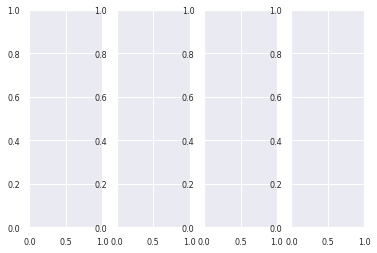

In [50]:
## PLOT WITH 4 SUBPLOTS: MULTI-SAMPLE ONE AUG, MULTI-AUG ONE SAMPLE, SINGLE-SAMPLE SINGLE-AUG

fig_4, axs_4 = plt.subplots(1,4)

selected_augs = ['nlp_random_contextual_word_insertion_distilroberta_base_embedding'
                , 'nlp_random_word_swap'
                , 'nlp_wordnet_synonym'
                , 'nlp_random_word_delete'
                , 'nlp_ppdb_synonym'
                , 'nlp_antonym']


# MULTI-SAMPLE, ONE AUG

# WORD-BASED FOUR SAMPLES

bert_path = OUTPUT_PATH + "civilcomments_ERM_predictions/bert.npy"

directory = OUTPUT_PATH + "civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/with_bert/"
word_aug_file_paths = []

for aug in all_word_augmentations:
    if aug in selected_augs:
        file_path = directory + aug + ".npy"
        word_aug_file_paths.append(file_path)
    
word_aug_file_paths.append(bert_path)


word_df = create_accuracy_graph(word_aug_file_paths, axs_4[0], plot_type = "box", title = "Word-based", plot_delta = True)


In [63]:
selected_multi_aug_multi_sample_ids = ['359',
 '360',
 '361',
 '362',
 '363',
 '364',
 '381',
 '382',
 '383',
 '384',
 '696',
 '697',
 '698',
 '699',
 '714']

aug_file_paths = []
directory = OUTPUT_PATH + "civilcomments_ERM_predictions_optimized_params_four_samples/multi_aug/averaged_with_bert/"

for aug in selected_multi_aug_multi_sample_ids:
    if aug in selected_multi_aug_multi_sample_ids:
        file_path = directory + aug + ".npy"
        aug_file_paths.append(file_path)
    
aug_file_paths.append(bert_path)


multi_multi_df = create_accuracy_graph(aug_file_paths, axs_4[0], plot_type = "box", title = "Word-based", plot_delta = True)



359


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [49]:
plt.show()

## FIGURE 5: SINGLE-SAMPLE, SINGLE-AUGMENTATION (CIVILCOMMENTS)

In [7]:
all_aug_file_paths = []

all_augs = all_char_augmentations + all_word_augmentations[:9]

for aug in all_augs:
    file_path = OUTPUT_PATH + "civilcomments_ERM_predictions_optimized_params/with_bert/" + aug + ".npy"
    all_aug_file_paths.append(file_path)
    
bert_path = OUTPUT_PATH + "civilcomments_ERM_predictions/bert.npy"
all_aug_file_paths.append(bert_path)

aug_to_acc = []

for file_name in all_aug_file_paths:

    augmentation_name = file_name.split('/')[-1].split('.')[0]
    print(augmentation_name)
    accuracies = calculate_accuracy(file_name, sampling_percent = 0.8, num_runs = 10)

    for i in range(len(accuracies)):
        accuracy = accuracies[i]
        aug_dict = {"augmentation":augmentation_name, "accuracy": accuracy, "batch_num": i}

        aug_to_acc.append(aug_dict)

    
acc_df = pd.DataFrame(aug_to_acc).sort_values('accuracy', ascending = False)
#print(acc_df)
    
threshhold_value = acc_df.loc[(acc_df["augmentation"] == "bert")]["accuracy"].mean()

filtered_acc_df = acc_df
filtered_acc_df["delta"] = filtered_acc_df["accuracy"] - threshhold_value

nlp_ocr


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_keyboard


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_char_insert


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_char_substitution


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_char_swap


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_char_deletion


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_word_swap


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_word_delete


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_wordnet_synonym


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_ppdb_synonym


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_antonym


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_token_split


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_spelling_substitution


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_insertion_distilroberta_base_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_substitution_squeezebert_uncased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

bert


  0%|          | 0/10 [00:00<?, ?it/s]

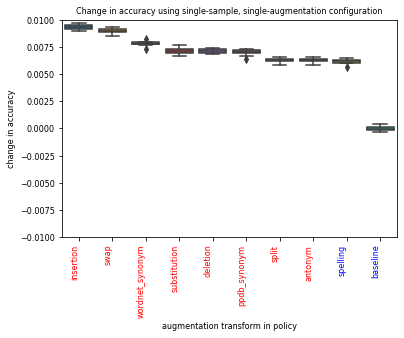

In [25]:
fig, axs = plt.subplots()
p = sns.boxplot(ax = axs, x = 'augmentation', y = "delta", data = filtered_acc_df)

axs.set_ylim(-0.01, 0.01)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90, ha='right')
axs.set_ylabel("change in accuracy")
axs.set_xlabel("augmentation transform in policy")

new_labels = []

for label in axs.get_xticklabels():
    new_label = abbreviated_mapping[label.get_text()]
    new_labels.append(new_label)

axs.set_xticklabels(new_labels)

x_ticks = axs.get_xticklabels()
for i in range(len(x_ticks)):
    if (i < 8):
        if x_ticks[i].get_text() != "baseline":
            x_ticks[i].set_color("red")
            
    else:
        x_ticks[i].set_color("blue")


axs.set_title("Change in accuracy using single-sample, single-augmentation configuration")

format_plot()

#fig.suptitle(title)
plt.savefig("single-single-PDF.pdf", format = "pdf", bbox_inches = "tight")
plt.show()



nlp_ocr


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_keyboard


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_char_insert


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_char_substitution


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_char_swap


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_char_deletion


  0%|          | 0/10 [00:00<?, ?it/s]

bert


  0%|          | 0/10 [00:00<?, ?it/s]

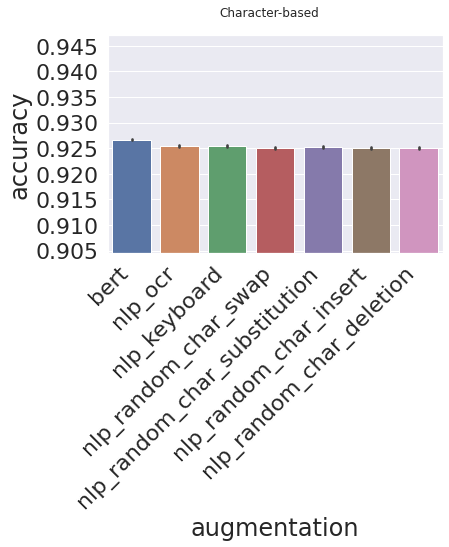

,augmentation,accuracy,batch_num
63,bert,0.927054,3
67,bert,0.926989,7
61,bert,0.926821,1
65,bert,0.926783,5
62,bert,0.926718,2
...,...,...,...
29,nlp_random_char_insert,0.924765,9
54,nlp_random_char_deletion,0.924737,4
26,nlp_random_char_insert,0.924672,6
58,nlp_random_char_deletion,0.924616,8


In [21]:


char_aug_file_paths = []

for char_aug in all_char_augmentations:
    file_path = OUTPUT_PATH + "civilcomments_ERM_predictions_optimized_params/with_bert/" + char_aug + ".npy"
    char_aug_file_paths.append(file_path)
    
bert_path = OUTPUT_PATH + "civilcomments_ERM_predictions/bert.npy"
char_aug_file_paths.append(bert_path)
    
create_accuracy_graph(char_aug_file_paths
                     , plot_type = 'box'
                     , title = "Character-based"
                     , plot_delta = True
                     , )

In [28]:
word_aug_file_paths = []

for word_aug in all_word_augmentations:
    file_path = OUTPUT_PATH + "civilcomments_ERM_predictions_optimized_params/with_bert/" + word_aug + ".npy"
    word_aug_file_paths.append(file_path)
    
bert_path = OUTPUT_PATH + "civilcomments_ERM_predictions/bert.npy"
word_aug_file_paths.append(bert_path)
    
create_accuracy_graph(word_aug_file_paths
                     , plot_type = 'bar'
                     , title = "Word-based"
                     , apply_threshhold = True)

nlp_random_word_swap


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_word_delete


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_wordnet_synonym


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_ppdb_synonym


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_antonym


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_spelling_substitution


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_insertion_bert_uncased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_insertion_bert_cased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_insertion_distilbert_uncased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_insertion_distilbert_cased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_insertion_roberta_base_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_insertion_distilroberta_base_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_insertion_bart_base_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_insertion_squeezebert_uncased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_substitution_bert_uncased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_substitution_bert_cased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

nlp_abstractive_summarization_bart_large_cnn


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_abstractive_summarization_t5_small


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_abstractive_summarization_t5_base


  0%|          | 0/10 [00:00<?, ?it/s]

bert


  0%|          | 0/10 [00:00<?, ?it/s]

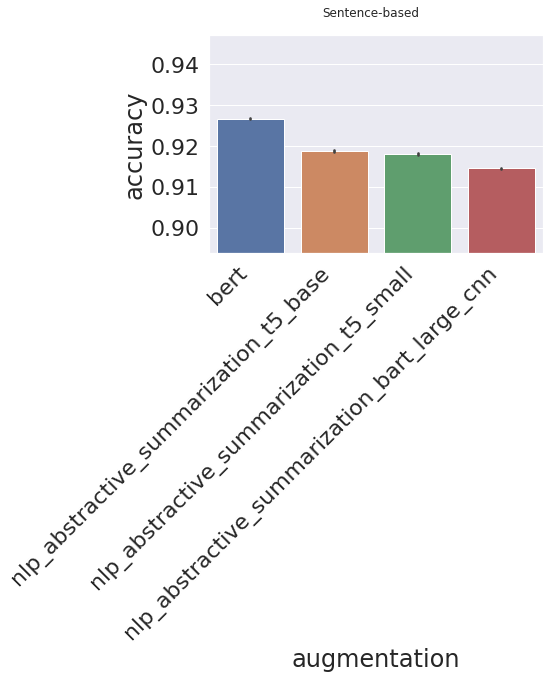

,augmentation,accuracy,batch_num
33,bert,0.927054,3
37,bert,0.926989,7
31,bert,0.926821,1
35,bert,0.926783,5
32,bert,0.926718,2
30,bert,0.926578,0
36,bert,0.926550,6
34,bert,0.926484,4
38,bert,0.926372,8
39,bert,0.926316,9


In [40]:
sentence_aug_file_paths = []

for sentence_aug in all_sentence_augmentations:
    file_path = OUTPUT_PATH + "civilcomments_ERM_predictions_optimized_params/with_bert/" + sentence_aug + ".npy"
    sentence_aug_file_paths.append(file_path)
    
bert_path = OUTPUT_PATH + "civilcomments_ERM_predictions/bert.npy"
sentence_aug_file_paths.append(bert_path)
    
create_accuracy_graph(sentence_aug_file_paths
                     , plot_type = 'bar'
                     , title = "Sentence-based")

nlp_ocr


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_keyboard


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_char_insert


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_char_substitution


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_char_swap


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_char_deletion


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_spelling_substitution


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_word_swap


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_word_delete


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_wordnet_synonym


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_ppdb_synonym


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_antonym


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_token_split


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_insertion_bert_uncased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_insertion_bert_cased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_insertion_distilbert_uncased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_insertion_distilbert_cased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_insertion_roberta_base_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_insertion_distilroberta_base_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_insertion_bart_base_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_insertion_squeezebert_uncased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_substitution_bert_uncased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_substitution_bert_cased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_substitution_distilbert_uncased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_substitution_distilbert_cased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_substitution_roberta_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_substitution_distilroberta_base_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_substitution_bart_base_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_substitution_squeezebert_uncased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_abstractive_summarization_bart_large_cnn


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_abstractive_summarization_t5_small


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_abstractive_summarization_t5_base


  0%|          | 0/10 [00:00<?, ?it/s]

bert


  0%|          | 0/10 [00:00<?, ?it/s]

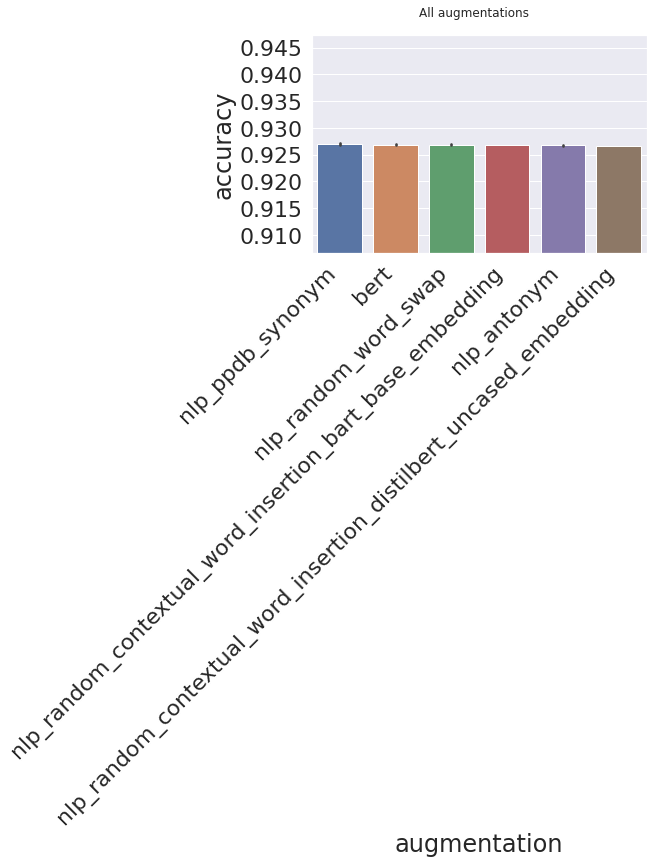

,augmentation,accuracy,batch_num
103,nlp_ppdb_synonym,0.927307,3
107,nlp_ppdb_synonym,0.927288,7
323,bert,0.927054,3
327,bert,0.926989,7
77,nlp_random_word_swap,0.926952,7
105,nlp_ppdb_synonym,0.926914,5
102,nlp_ppdb_synonym,0.926868,2
73,nlp_random_word_swap,0.926868,3
197,nlp_random_contextual_word_insertion_bart_base...,0.926830,7
321,bert,0.926821,1


In [41]:
all_aug_file_paths = []

all_augmentations = all_char_augmentations + all_word_augmentations + all_sentence_augmentations

for sentence_aug in all_augmentations:
    file_path = OUTPUT_PATH + "civilcomments_ERM_predictions_optimized_params/with_bert/" + sentence_aug + ".npy"
    all_aug_file_paths.append(file_path)
    
bert_path = OUTPUT_PATH + "civilcomments_ERM_predictions/bert.npy"
all_aug_file_paths.append(bert_path)
    
create_accuracy_graph(all_aug_file_paths
                     , plot_type = 'bar'
                     , title = "All augmentations"
                     , apply_threshhold = True)

## FIGURE 4B: SINGLE-SAMPLE, SINGLE-AUGMENTATION (AMAZON)

In [35]:
char_aug_file_paths = []

for char_aug in all_char_augmentations:
    file_path = OUTPUT_PATH + "amazon_ERM_predictions_optimized_params/with_bert/" + char_aug + ".npy"
    char_aug_file_paths.append(file_path)
    
bert_path = OUTPUT_PATH + "amazon_ERM_predictions_optimized_params/bert.npy"
char_aug_file_paths.append(bert_path)
    
create_accuracy_graph(char_aug_file_paths
                     , plot_type = 'bar'
                     , title = "Character-based")

nlp_ocr


  0%|          | 0/10 [00:00<?, ?it/s]

IndexError: index 366725 is out of bounds for axis 0 with size 100050

In [36]:
word_aug_file_paths = []

for word_aug in all_word_augmentations:
    file_path = OUTPUT_PATH + "amazon_ERM_predictions_optimized_params/with_bert/" + word_aug + ".npy"
    word_aug_file_paths.append(file_path)
    
bert_path = OUTPUT_PATH + "amazon_ERM_predictions_optimized_params/bert.npy"
word_aug_file_paths.append(bert_path)
    
create_accuracy_graph(word_aug_file_paths
                     , plot_type = 'bar'
                     , title = "Character-based")

nlp_random_word_swap


FileNotFoundError: [Errno 2] No such file or directory: '/data/ddmg/prism/tta/outputs/amazon_ERM_predictions_optimized_params/with_bert/nlp_random_word_swap.npy'

In [44]:
all_aug_file_paths = []

amazon_file_paths = OUTPUT_PATH + "amazon_ERM_predictions_optimized_params/with_bert/"

amazon_aug_file_paths = os.listdir(amazon_file_paths)

for aug in amazon_aug_file_paths:
    file_path = OUTPUT_PATH + "amazon_ERM_predictions_optimized_params/with_bert/" + aug
    all_aug_file_paths.append(file_path)
    
create_accuracy_graph(all_aug_file_paths
                     , plot_type = 'bar'
                     , title = "All augmentations"
                     , apply_threshhold = False)

nlp_wordnet_synonym


  0%|          | 0/10 [00:00<?, ?it/s]

IndexError: index 366725 is out of bounds for axis 0 with size 100050

## FIGURE 5A: SINGLE-SAMPLE, MULTI-AUGMENTATION (CIVILCOMMENTS)

30


  0%|          | 0/1 [00:00<?, ?it/s]

7


  0%|          | 0/1 [00:00<?, ?it/s]

9


  0%|          | 0/1 [00:00<?, ?it/s]

14


  0%|          | 0/1 [00:00<?, ?it/s]

13


  0%|          | 0/1 [00:00<?, ?it/s]

28


  0%|          | 0/1 [00:00<?, ?it/s]

26


  0%|          | 0/1 [00:00<?, ?it/s]

21


  0%|          | 0/1 [00:00<?, ?it/s]

8


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

6


  0%|          | 0/1 [00:00<?, ?it/s]

31


  0%|          | 0/1 [00:00<?, ?it/s]

20


  0%|          | 0/1 [00:00<?, ?it/s]

27


  0%|          | 0/1 [00:00<?, ?it/s]

29


  0%|          | 0/1 [00:00<?, ?it/s]

12


  0%|          | 0/1 [00:00<?, ?it/s]

15


  0%|          | 0/1 [00:00<?, ?it/s]

24


  0%|          | 0/1 [00:00<?, ?it/s]

23


  0%|          | 0/1 [00:00<?, ?it/s]

18


  0%|          | 0/1 [00:00<?, ?it/s]

16


  0%|          | 0/1 [00:00<?, ?it/s]

11


  0%|          | 0/1 [00:00<?, ?it/s]

5


  0%|          | 0/1 [00:00<?, ?it/s]

2


  0%|          | 0/1 [00:00<?, ?it/s]

32


  0%|          | 0/1 [00:00<?, ?it/s]

35


  0%|          | 0/1 [00:00<?, ?it/s]

10


  0%|          | 0/1 [00:00<?, ?it/s]

17


  0%|          | 0/1 [00:00<?, ?it/s]

19


  0%|          | 0/1 [00:00<?, ?it/s]

22


  0%|          | 0/1 [00:00<?, ?it/s]

25


  0%|          | 0/1 [00:00<?, ?it/s]

34


  0%|          | 0/1 [00:00<?, ?it/s]

33


  0%|          | 0/1 [00:00<?, ?it/s]

3


  0%|          | 0/1 [00:00<?, ?it/s]

4


  0%|          | 0/1 [00:00<?, ?it/s]

bert


  0%|          | 0/1 [00:00<?, ?it/s]

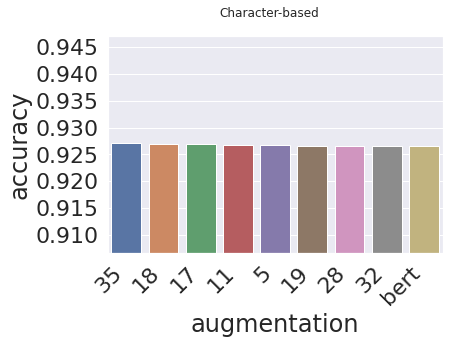

,augmentation,accuracy,batch_num
25,35,0.927139,0
19,18,0.926942,0
27,17,0.926905,0
21,11,0.926840,0
22,5,0.926699,0
28,19,0.926653,0
5,28,0.926643,0
24,32,0.926625,0
35,bert,0.926578,0


In [6]:
plotted_accuracies = []
directory = OUTPUT_PATH + 'civilcomments_ERM_predictions_optimized_params/single_sample_four_optimized_aug/char_based/'
bert_path = OUTPUT_PATH + 'civilcomments_ERM_predictions/bert.npy'


for file in os.listdir(directory):
    if file.split('.')[-1] == 'npy':
        plotted_accuracies.append(directory + file)

plotted_accuracies.append(bert_path)


df = create_accuracy_graph(plotted_accuracies, "bar", num_runs = 1, plot = True, apply_threshhold = True, title = "Character-based")

#df.groupby("augmentation", as_index = False).mean().sort_values(by=['accuracy'], ascending=False)

"""
top_35_quads = df.groupby("augmentation", as_index = False).mean().sort_values(by=['accuracy'], ascending=False)[:35]
top_35_quad_ids = top_35_quads["augmentation"].tolist()


top_accuracies = []

for quad in top_35_quad_ids:
    file = directory + str(quad) + ".npy"
    top_accuracies.append(file)


top_accuracies.append('./data/civilcomments_ERM_predictions/bert.npy')


top_35_df = create_accuracy_graph(plotted_accuracies, "bar", num_runs = 10)
"""

df

In [9]:
char_combo_file = OUTPUT_PATH + "civilcomments_ERM_predictions_optimized_params/single_sample_four_optimized_aug/char_based/combo_id_to_combo.txt"

with open(char_combo_file, 'r') as file:
    combo_dict = json.load(file)
    
combo_id_to_combo_name = {}

char_aug_directory = OUTPUT_PATH + 'civilcomments_ERM_predictions_optimized_params/single_sample_four_optimized_aug/char_based/'

for combo_id in df["augmentation"].tolist():
    
    if combo_id != "bert":
        
        improved_combo = combo_dict[str(combo_id)]
        combo_id_to_combo_name[combo_id] = improved_combo

combo_names = pd.DataFrame(combo_id_to_combo_name).transpose()
    
combo_names

,0,1,2,3,4
35,nlp_spelling_substitution,nlp_random_char_deletion,nlp_random_char_insert,nlp_keyboard,bert
18,nlp_ocr,nlp_spelling_substitution,nlp_random_char_deletion,nlp_keyboard,bert
17,nlp_ocr,nlp_spelling_substitution,nlp_random_char_deletion,nlp_random_char_insert,bert
11,nlp_ocr,nlp_random_char_substitution,nlp_spelling_substitution,nlp_random_char_deletion,bert
5,nlp_ocr,nlp_random_char_swap,nlp_spelling_substitution,nlp_random_char_deletion,bert
19,nlp_ocr,nlp_spelling_substitution,nlp_random_char_insert,nlp_keyboard,bert
28,nlp_random_char_swap,nlp_spelling_substitution,nlp_random_char_deletion,nlp_keyboard,bert
32,nlp_random_char_substitution,nlp_spelling_substitution,nlp_random_char_deletion,nlp_keyboard,bert


In [31]:
plotted_accuracies = []
combo_ids = ["563", "539", "548", "396"]

directory = OUTPUT_PATH + 'civilcomments_ERM_predictions_optimized_params/single_sample_four_optimized_aug/word_based/'
bert_path = OUTPUT_PATH + 'civilcomments_ERM_predictions/bert.npy'

for combo_id in combo_ids:
    path = directory + combo_id + '.npy'
    plotted_accuracies.append(path)


plotted_accuracies.append(bert_path)


aug_to_acc = []

for file_name in plotted_accuracies:

    augmentation_name = file_name.split('/')[-1].split('.')[0]
    print(augmentation_name)
    accuracies = calculate_accuracy(file_name, sampling_percent = 0.8, num_runs = 10)

    for i in range(len(accuracies)):
        accuracy = accuracies[i]
        aug_dict = {"augmentation":augmentation_name, "accuracy": accuracy, "batch_num": i}

        aug_to_acc.append(aug_dict)

    
acc_df = pd.DataFrame(aug_to_acc).sort_values('accuracy', ascending = False)
#print(acc_df)
    
threshhold_value = acc_df.loc[(acc_df["augmentation"] == "bert")]["accuracy"].mean()

filtered_acc_df = acc_df
filtered_acc_df["delta"] = filtered_acc_df["accuracy"] - threshhold_value

#df = create_accuracy_graph(plotted_accuracies, "bar", num_runs = 1, plot = False, apply_threshhold = True)

#df.groupby("augmentation", as_index = False).mean().sort_values(by=['accuracy'], ascending=False)

#print(len(df.index)) #357


563


  0%|          | 0/10 [00:00<?, ?it/s]

539


  0%|          | 0/10 [00:00<?, ?it/s]

548


  0%|          | 0/10 [00:00<?, ?it/s]

396


  0%|          | 0/10 [00:00<?, ?it/s]

bert


  0%|          | 0/10 [00:00<?, ?it/s]

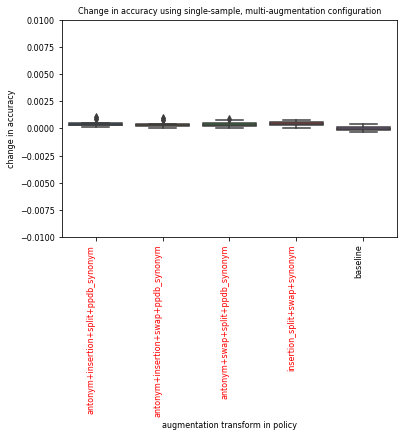

In [34]:
fig, axs = plt.subplots()
p = sns.boxplot(ax = axs, x = 'augmentation', y = "delta", data = filtered_acc_df)

axs.set_ylim(-0.01, 0.01)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90, ha='right')
axs.set_ylabel("change in accuracy")
axs.set_xlabel("augmentation transform in policy")


new_labels = ["antonym+insertion+split+ppdb_synonym"
             , "antonym+insertion+swap+ppdb_synonym"
             , "antonym+swap+split+ppdb_synonym"
             , "insertion_split+swap+synonym"
             , "baseline"]


axs.set_xticklabels(new_labels)

x_ticks = axs.get_xticklabels()

for i in range(len(x_ticks)):
    if x_ticks[i].get_text() != "baseline":
            x_ticks[i].set_color("red")
            
    else:
        x_ticks[i].set_color("black")


axs.set_title("Change in accuracy using single-sample, multi-augmentation configuration")

format_plot()

#fig.suptitle(title)
plt.savefig("single-multi-PDF.pdf", format = "pdf", bbox_inches = "tight")
plt.show()




396


  0%|          | 0/10 [00:00<?, ?it/s]

430


  0%|          | 0/10 [00:00<?, ?it/s]

475


  0%|          | 0/10 [00:00<?, ?it/s]

539


  0%|          | 0/10 [00:00<?, ?it/s]

402


  0%|          | 0/10 [00:00<?, ?it/s]

479


  0%|          | 0/10 [00:00<?, ?it/s]

650


  0%|          | 0/10 [00:00<?, ?it/s]

548


  0%|          | 0/10 [00:00<?, ?it/s]

478


  0%|          | 0/10 [00:00<?, ?it/s]

563


  0%|          | 0/10 [00:00<?, ?it/s]

bert


  0%|          | 0/10 [00:00<?, ?it/s]

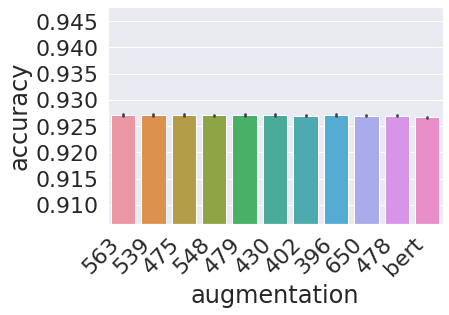

In [30]:
directory = directory = OUTPUT_PATH + 'civilcomments_ERM_predictions_optimized_params/single_sample_four_optimized_aug/word_based/'


top_10_quads = df.groupby("augmentation", as_index = False).mean().sort_values(by=['accuracy'], ascending=False)[:10]
top_10_quad_ids = top_10_quads["augmentation"].tolist()


top_accuracies = []

for quad in top_10_quad_ids:
    file = directory + str(quad) + ".npy"
    top_accuracies.append(file)


top_accuracies.append(bert_path)


top_10_df = create_accuracy_graph(top_accuracies, "bar", num_runs = 10)

In [31]:
top_10_df.groupby("augmentation", as_index = False).mean().sort_values(by=['accuracy'], ascending=False)


,augmentation,accuracy,batch_num
3,475,0.927112,4.5
8,563,0.927100,4.5
5,479,0.927077,4.5
0,396,0.927077,4.5
2,430,0.927067,4.5
6,539,0.927057,4.5
7,548,0.927025,4.5
9,650,0.927000,4.5
1,402,0.926972,4.5
4,478,0.926959,4.5


In [33]:
word_combo_file = OUTPUT_PATH + "civilcomments_ERM_predictions_optimized_params/single_sample_four_optimized_aug/word_based/combo_id_to_combo.txt"

with open(word_combo_file, 'r') as file:
    combo_dict = json.load(file)
    
combo_id_to_combo_name = {}

word_aug_directory = OUTPUT_PATH + 'civilcomments_ERM_predictions_optimized_params/single_sample_four_optimized_aug/word_based/'

for combo_id in top_10_df["augmentation"].tolist():
    
    if combo_id != "bert":
        
        improved_combo = combo_dict[str(combo_id)]
        combo_id_to_combo_name[combo_id] = improved_combo

combo_names = pd.DataFrame(combo_id_to_combo_name).transpose()
    
combo_names

,0,1,2,3,4
563,nlp_antonym,nlp_random_contextual_word_insertion_distilrob...,nlp_random_token_split,nlp_ppdb_synonym,bert
539,nlp_antonym,nlp_random_word_swap,nlp_random_contextual_word_insertion_distilrob...,nlp_ppdb_synonym,bert
475,nlp_random_contextual_word_insertion_distilber...,nlp_random_contextual_word_insertion_distilrob...,nlp_random_word_substitute,nlp_ppdb_synonym,bert
548,nlp_antonym,nlp_random_word_swap,nlp_random_token_split,nlp_ppdb_synonym,bert
479,nlp_random_contextual_word_insertion_distilber...,nlp_random_contextual_word_insertion_distilrob...,nlp_random_token_split,nlp_ppdb_synonym,bert
430,nlp_random_contextual_word_insertion_distilber...,nlp_random_contextual_word_insertion_distilber...,nlp_random_contextual_word_insertion_distilrob...,nlp_random_token_split,bert
402,nlp_random_contextual_word_insertion_distilber...,nlp_antonym,nlp_random_contextual_word_insertion_distilrob...,nlp_random_token_split,bert
396,nlp_random_contextual_word_insertion_distilber...,nlp_antonym,nlp_random_word_swap,nlp_random_token_split,bert
650,nlp_random_word_swap,nlp_random_contextual_word_insertion_distilrob...,nlp_random_word_substitute,nlp_ppdb_synonym,bert
478,nlp_random_contextual_word_insertion_distilber...,nlp_random_contextual_word_insertion_distilrob...,nlp_random_token_split,nlp_wordnet_synonym,bert


## FIGURE 5B: SINGLE-SAMPLE, MULTI-AUGMENTATION (AMAZON)

## FIGURE 6A: MULTI-SAMPLE, SINGLE-AUGMENTATION (WILDS)

['/data/ddmg/prism/tta/outputs/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/with_bert/nlp_ocr.npy', '/data/ddmg/prism/tta/outputs/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/with_bert/nlp_keyboard.npy', '/data/ddmg/prism/tta/outputs/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/with_bert/nlp_random_char_insert.npy', '/data/ddmg/prism/tta/outputs/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/with_bert/nlp_random_char_substitution.npy', '/data/ddmg/prism/tta/outputs/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/with_bert/nlp_random_char_swap.npy', '/data/ddmg/prism/tta/outputs/civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/with_bert/nlp_random_char_deletion.npy', '/data/ddmg/prism/tta/outputs/civilcomments_ERM_predictions/bert.npy']
nlp_ocr


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_keyboard


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_char_insert


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_char_substitution


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_char_swap


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_char_deletion


  0%|          | 0/10 [00:00<?, ?it/s]

bert


  0%|          | 0/10 [00:00<?, ?it/s]

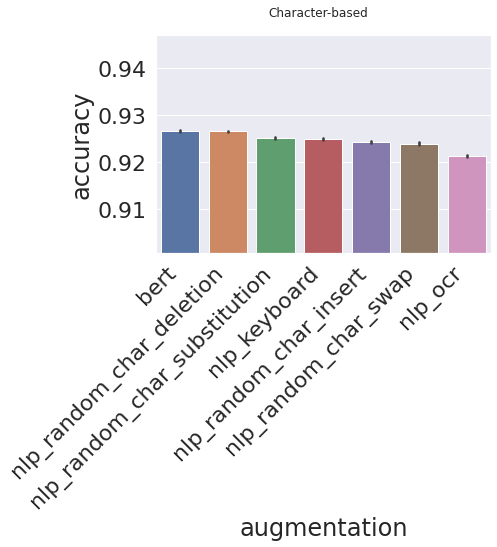

,augmentation,accuracy,batch_num
63,bert,0.927054,3
67,bert,0.926989,7
57,nlp_random_char_deletion,0.926942,7
61,bert,0.926821,1
65,bert,0.926783,5
...,...,...,...
0,nlp_ocr,0.921317,0
8,nlp_ocr,0.921149,8
5,nlp_ocr,0.921037,5
3,nlp_ocr,0.920953,3


In [22]:
# CHARACTER-BASED FOUR SAMPLES

directory = OUTPUT_PATH + "civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/with_bert/"
char_aug_file_paths = []

for aug in all_char_augmentations:
    file_path = directory + aug + ".npy"
    char_aug_file_paths.append(file_path)
    
char_aug_file_paths.append(bert_path)

print(char_aug_file_paths)

create_accuracy_graph(char_aug_file_paths, plot_type = "bar", title = "Character-based")

In [21]:
# WORD-BASED FOUR SAMPLES

directory = OUTPUT_PATH + "civilcomments_ERM_predictions_optimized_params_four_samples/averaged_sample_group/with_bert/"
word_aug_file_paths = []

for aug in all_word_augmentations[:9]:
    file_path = directory + aug + ".npy"
    word_aug_file_paths.append(file_path)
    
word_aug_file_paths.append(bert_path)

    
bert_path = OUTPUT_PATH + "civilcomments_ERM_predictions/bert.npy"
word_aug_file_paths.append(bert_path)

aug_to_acc = []

for file_name in word_aug_file_paths:

    augmentation_name = file_name.split('/')[-1].split('.')[0]
    print(augmentation_name)
    
    if augmentation_name != "nlp_random_token_split":
        accuracies = calculate_accuracy(file_name, sampling_percent = 0.8, num_runs = 10)

    for i in range(len(accuracies)):
        accuracy = accuracies[i]
        aug_dict = {"augmentation":augmentation_name, "accuracy": accuracy, "batch_num": i}

        aug_to_acc.append(aug_dict)

    
acc_df = pd.DataFrame(aug_to_acc).sort_values('accuracy', ascending = False)
#print(acc_df)
    
threshhold_value = acc_df.loc[(acc_df["augmentation"] == "bert")]["accuracy"].mean()

filtered_acc_df = acc_df
filtered_acc_df["delta"] = filtered_acc_df["accuracy"] - threshhold_value

nlp_random_word_swap


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_word_delete


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_wordnet_synonym


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_ppdb_synonym


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_antonym


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_token_split
nlp_spelling_substitution


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_insertion_distilroberta_base_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_contextual_word_substitution_squeezebert_uncased_embedding


  0%|          | 0/10 [00:00<?, ?it/s]

bert


  0%|          | 0/10 [00:00<?, ?it/s]

bert


  0%|          | 0/10 [00:00<?, ?it/s]

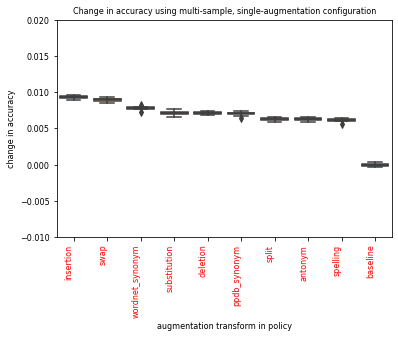

In [24]:
fig, axs = plt.subplots()
p = sns.boxplot(ax = axs, x = 'augmentation', y = "delta", data = filtered_acc_df)

axs.set_ylim(Y_AXIS_MIN, Y_AXIS_MAX)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90, ha='right')
axs.set_ylabel("change in accuracy")
axs.set_xlabel("augmentation transform in policy")

new_labels = []

x_ticks = axs.get_xticklabels()

for label in x_ticks:
    new_label = abbreviated_mapping[label.get_text()]
    new_labels.append(new_label)

axs.set_xticklabels(new_labels)


for i in range(len(x_ticks)):
    x_ticks[i].set_color("red")
            
    
axs.set_title("Change in accuracy using multi-sample, single-augmentation configuration")

format_plot()

#fig.suptitle(title)
plt.savefig("multi-single-PDF.pdf", format = "pdf", bbox_inches = "tight")
plt.show()




In [ ]:
improved_augs = ['nlp_spelling_substitution'
                 , 'nlp_random_contextual_word_insertion_distilroberta_base_embedding'
                 , 'nlp_random_contextual_word_insertion_roberta_base_embedding'
                 , 'nlp_random_contextual_word_insertion_distilbert_uncased_embedding'
                 , 'nlp_random_contextual_word_insertion_distilbert_cased_embedding'
                 , 'nlp_random_contextual_word_substitution_bert_uncased_embedding'
                 , 'nlp_random_word_swap'
                 , 'nlp_random_contextual_word_insertion_bart_base_embedding'
                 , 'nlp_random_contextual_word_insertion_squeezebert_uncased_embedding'
                 , 'nlp_random_word_delete'
                 , 'nlp_wordnet_synonym'
                 , 'nlp_ppdb_synonym'
                 , 'nlp_antonym'
                ]


## FIGURE 6B: MULTI-SAMPLE, SINGLE-AUGMENTATION (AMAZON)

## FIGURE 7A: MULTI-SAMPLE, MULTI-AUGMENTATION (CIVILCOMMENTS)

In [ ]:
"""
[a, a, a]
[a, a, a]
[a, a, a]
[a, a, a]
[b, b, b]
...

"""



## FIGURE 7B: MULTI-SAMPLE, MULTI-AUGMENTATION (AMAZON)